# Notes about the SAS's Course
# Predictive Modeling Using Logistic Regression (15.1)

This course covers predictive modeling using SAS/STAT software with emphasis on the LOGISTIC procedure. This course also discusses selecting variables and interactions, recoding categorical variables based on the smooth weight of evidence, assessing models, treating missing values, and using efficiency techniques for massive data sets. This notes are based in the course materials, some codes and images are copyrighted by Sas Institute. I made a Jupyter Notebook using JupiterLab with SAS University Edition.

In [4]:
/*Run this script to configurate the session*/

%let InicioCurso=/folders/myfolders/Cursos/EPMLR51/;
%include "&InicioCurso/setup.sas";

## Lesson 2: Fitting the Model


#### Fitting a Basic Logistic Regression Model, Part 1

First create the training and validation data.

In [5]:
data work.develop;
   set pmlr.develop;
run;

%global inputs;
%let inputs=ACCTAGE DDA DDABAL DEP DEPAMT CASHBK 
            CHECKS DIRDEP NSF NSFAMT PHONE TELLER 
            SAV SAVBAL ATM ATMAMT POS POSAMT CD 
            CDBAL IRA IRABAL LOC LOCBAL INV 
            INVBAL ILS ILSBAL MM MMBAL MMCRED MTG 
            MTGBAL CC CCBAL CCPURC SDB INCOME 
            HMOWN LORES HMVAL AGE CRSCORE MOVED 
            INAREA;

proc means data=work.develop n nmiss mean min max;
   var &inputs;
run;

proc freq data=work.develop;
   tables ins branch res;
run;



/***************************************************************************/

/* Sort the data by the target in preparation for stratified sampling. */

proc sort data=work.develop out=work.develop_sort; 
   by ins; 
run;

/* The SURVEYSELECT procedure will perform stratified sampling 
   on any variable in the STRATA statement. The OUTALL option 
   specifies that you want a flag appended to the file to 
   indicate selected records, not simply a file comprised 
   of the selected records. */

proc surveyselect noprint data=work.develop_sort 
                  samprate=.6667 stratumseed=restore
                  out=work.develop_sample
                  seed=44444 outall;
   strata ins;
run;

/* Verify stratification. */

proc freq data=work.develop_sample;
   tables ins*selected;
run;

/* Create training and validation data sets. */

data work.train(drop=selected SelectionProb SamplingWeight) 
     work.valid(drop=selected SelectionProb SamplingWeight);
   set work.develop_sample;
   if selected then output work.train;
   else output work.valid;
run;


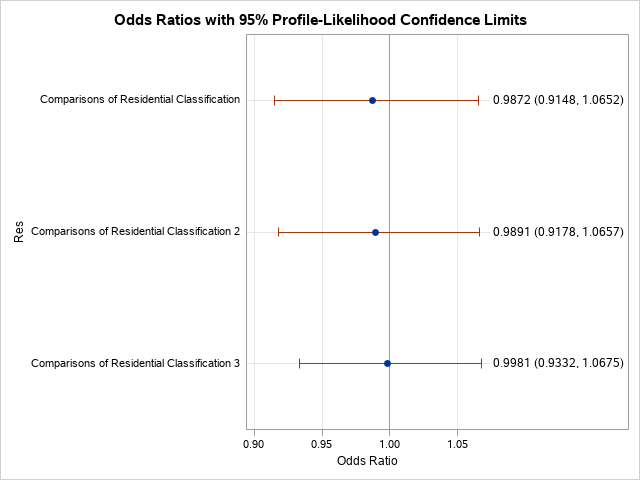
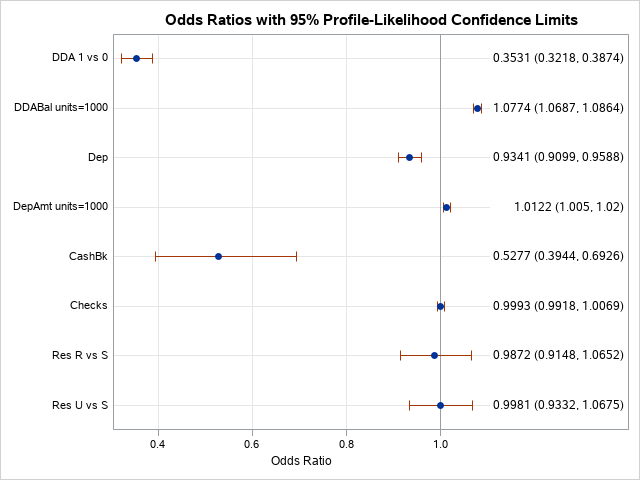
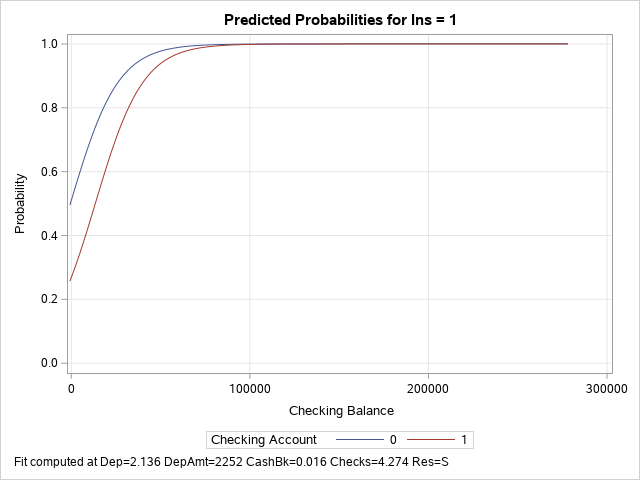
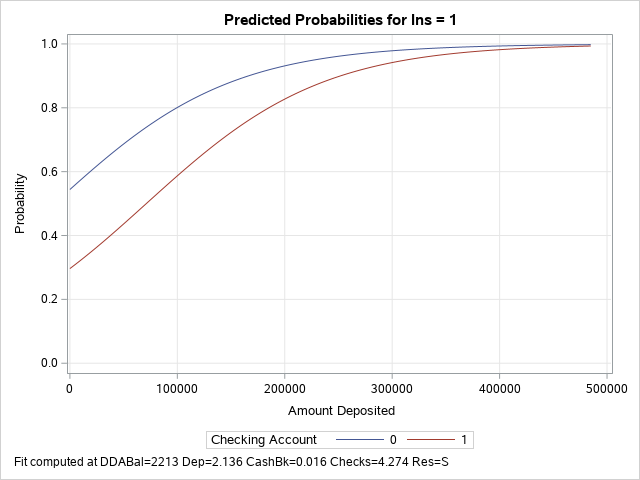
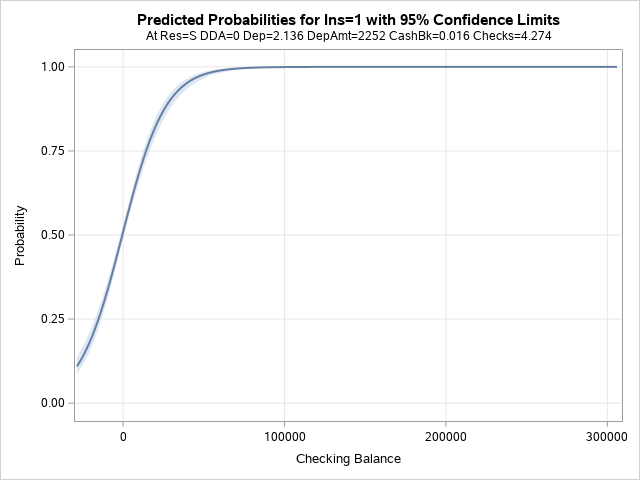
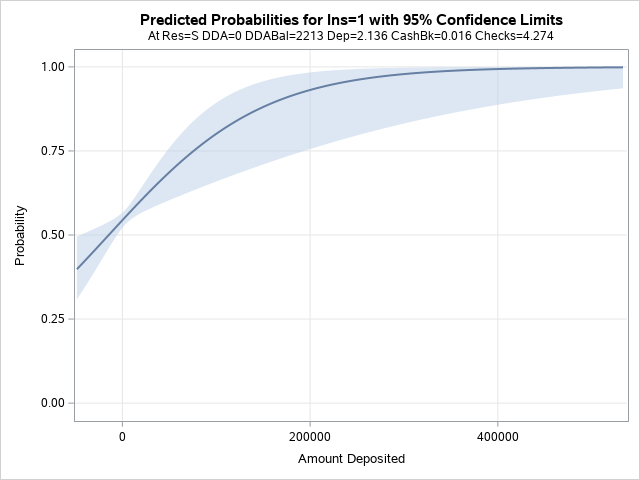
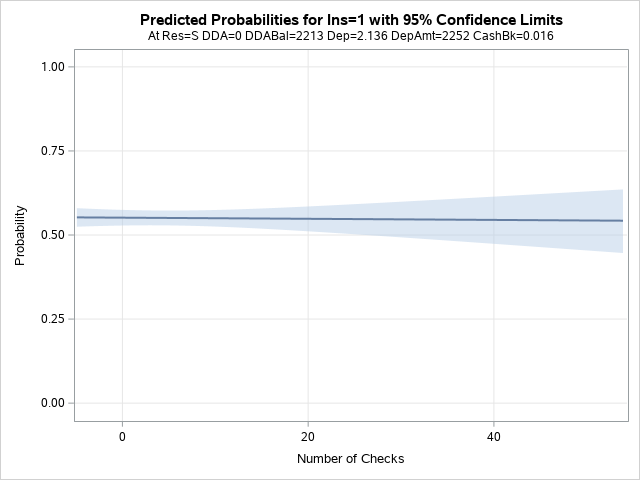
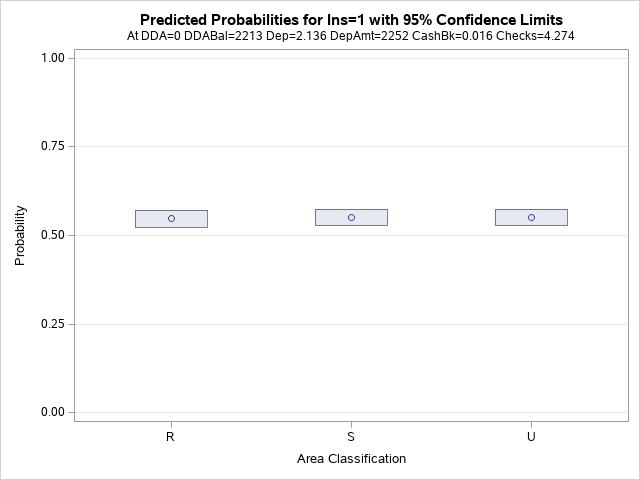

In [4]:
title 'Show the data source';
proc print data=work.train(obs=3); run; 
title;


title1 "Logistic Regression Model for the Variable Annuity Data Set";
proc logistic data=work.train 
              plots(only maxpoints=none)=(effect(clband x=(ddabal depamt checks res))
              
              /*ONLY (suppresses the default plots). Only specifically requested plot requests are displayed.*/
              /*maxpoints=none, (requests that no observations be displayed in the effect plots). */
              /*We have the effect plots. That displays and enhances the effect plots for the model that will 
              have the probabilities on the Y axis and the values of the predictor variables on the X axis.*/
              /*CLBAND that displays confidence limits on the plots.*/
              /*We also have X=. That specifies effects to be used on the X axis of the effect plots. You can specify several X axes.*/
              
              oddsratio (type=horizontalstat));
              
              /*We also have an odds ratio plot request that displays and enhances the odds ratio plots for the model when the CLODDS= option, or
              ODDSRATIO statements, are also specified.*/
              /*TYPE=horizontalstat displays the values of the odds ratios and their confidence limits on the right side of the graphic, 
              and this option places the odds ratio values on the X axis.*/
              
   class res (param=ref ref='S') dda (param=ref ref='0');
   
   /*CLASS statement that specifies the classification variables to be used in the analysis. The CLASS statement must precede the MODEL 
   statement.*/
   /*PARAM= option (that's a selected CLASS statement option) that specifies the parameterization method for the classification variable 
   or variables.*/
   /*REF= option that specifies the reference level, and the reference level here is S for suburb.*/
   /*DDA (checking account) as a class variable with reference cell parameterization and a reference cell of 0.*/
   
   model ins(event='1')=dda ddabal dep depamt 
   
   /*MODEL statement specifies the response variable and the predictor variables, which can be character or numeric.*/
   /*EVENT= option. That specifies the event category for the binary response model. has no effect when there are more than 
   two response categories.*/
   
   
               cashbk checks res / stb clodds=pl;
               
               /*STB: requests that standardized estimates for the parameters be printed for the predictor variables.*/
               /*clodds=pl that requests confidence intervals for the odds ratios, and we're going to use the profile likelihood confidence interval.*/
   
   units ddabal=1000 depamt=1000 / default=1;
   
   /*UNITS statement that enables you to obtain an odds ratio estimate for a specified change in a predictor variable.(number, standard deviation, or a 
   number times the standard deviation.). here 1,000-unit increase in checking account balance and a 1,000-unit increase in deposit amount.*/
   /*DEFAULT=, and that gives a list of units of change for all the predictor variables that are not specified in the UNITS statement. So here we have default=1.*/
   /*If the DEFAULT option is not specified, PROC LOGISTIC does not produce customized odds ratio estimates for any predictive variable that is not listed in the 
   UNITS statement.*/

   oddsratio 'Comparisons of Residential Classification' res / diff=all cl=pl;
   
   /*ODDSRATIO statement. That produces odds ratios for variables. can specify several ODDSRATIO statements.*/
   /*DIFF=ALL option that specifies whether the odds ratios for a classification variable are computed against their reference level or all pairs of variables are 
   compared. Here, we're using DIFF=ALL, so we're going to have all possible comparisons.*/
   /*CL=PL, and that specifies that we're creating profile likelihood confidence limits for the odds ratios. */
   
   
   effectplot slicefit(sliceby=dda x=ddabal) / noobs;
   effectplot slicefit(sliceby=dda x=depamt) / noobs;   
   
   /*EFFECTPLOT statement that produces a display of the fitted model and provides options for changing and enhancing the displays.*/
   /*SLICEFIT. That displays a curve of predicted values versus a continuous variable grouped by the levels of a class effect.*/
   /*SLICEBY=DDA that displays the fitted values at the different levels of, in this case, DDA (checking account), and that is why I have DDA as a class variable.*/
   /*X= option specifies values to display on the X axis. */
   /* NOOBS suppresses the display of observations.*/
   /*sliceby=dda x=depamt. So here, we're going to have the deposit amount on the X axis with the NOOBS option.*/

run;
title1;


* The Type 3 Analysis of Effects table shows which input variables are statistically significant, controlling for all of the other input variables in the model.
* The c statistic is the probability of an observation with an event having a higher predicted probability than an observation without the event.

#### Scoring New Cases

One of the main purposes of predictive modeling is to score new cases—in other words, to build a model and then apply the model to new data to get a predicted probability for each new observation. You simply enter the new data input values into your logistic regression model to get a new predicted probability.

...


#### Correcting for Oversampling

...

#### Practice: Fitting a Logistic Regression Model
For the veterans' organization project, fit a logistic regression model to the pmlr.pva_train data set and use ODS statistical graphics to display the results.
1. Create a global macro variable named ex_pi1 that stores π1, the proportion of responders in the population. Note: To find the proportion of responders in the population, review the pva_raw_data data set description.

In [6]:
%global ex_pi1;
%let ex_pi1=0.05;

2. Add a PROC LOGISTIC step that does the following:
* fits a logistic regression model with Target_B as the target variable, and Pep_Star, Recent_Avg_Gift_Amt, and Frequency_Status_97NK as the input variables.
* models the probability that the target variable equals 1, and requests 95% profile likelihood confidence intervals for the odds ratio.
* uses the SCORE statement to create a temporary data set called scopva_train, which contains the data from the pva_train data set and the predicted probability of the event, correcting for oversampling.0
* creates effect plots with confidence bands for the three input variables
* creates effect plots of Recent_Avg_Gift_Amt by Pep_Star and Frequency_Status_97NK by PEP_STAR
* creates an odds ratio plot with a horizontal orientation and displays the statistics
* uses the ONLY global plot option to suppress the default plots

Note: To avoid a warning in the log about the suppression of plots that have more than 5000 observations, you can add the following MAXPOINTS= option to the PROC LOGISTIC statement: plots(maxpoints=none only). This change is optional. Omitting the MAXPOINTS= option does not affect the results of the practices in this course.


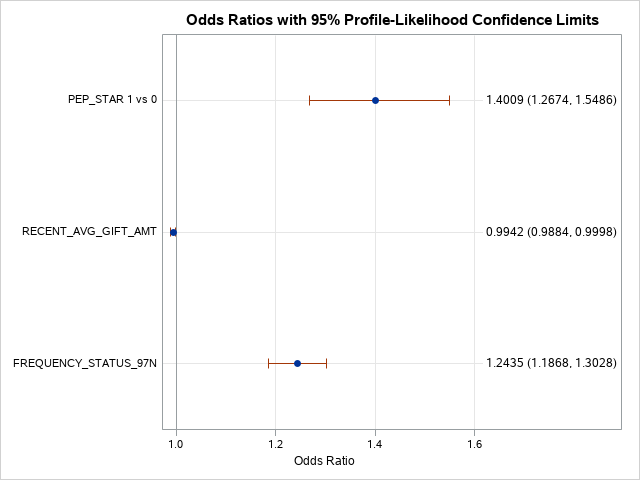
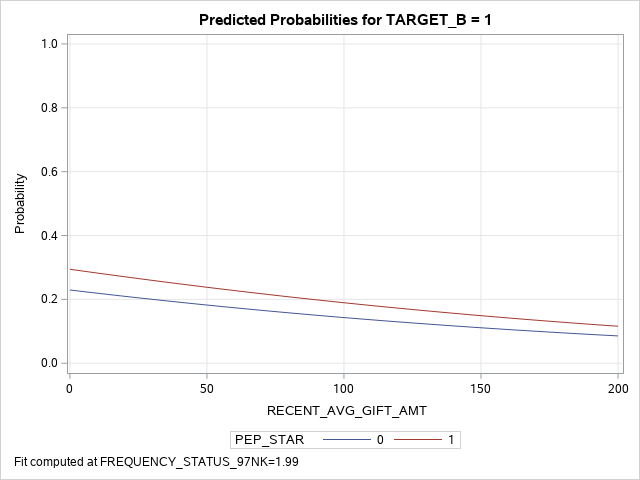
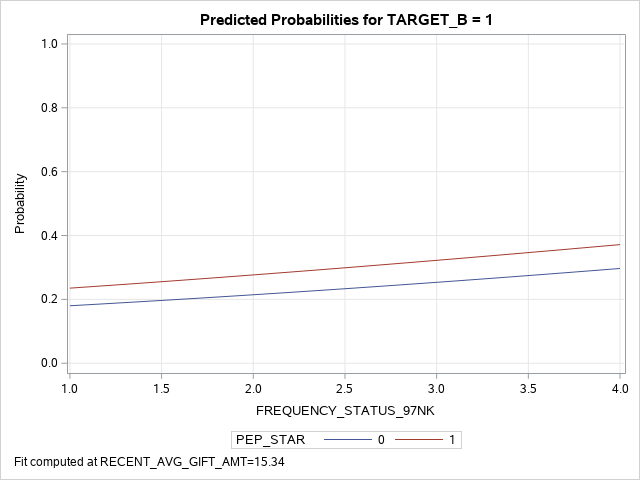
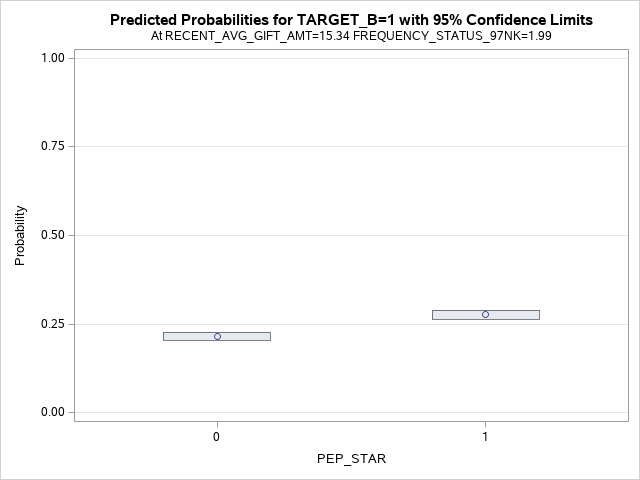
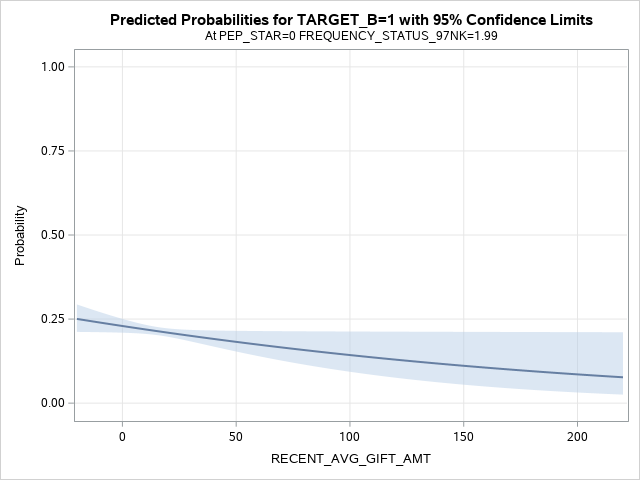
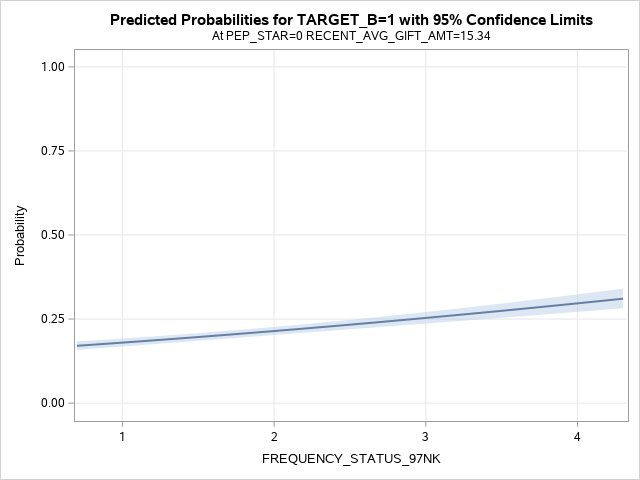

In [7]:
title1 "Logistic Regression Model of the Veterans' Organization Data";
proc logistic data=pmlr.pva_train plots(only)=
              (effect(clband x=(pep_star recent_avg_gift_amt
              frequency_status_97nk)) oddsratio (type=horizontalstat));
   class pep_star (param=ref ref='0');
   model target_b(event='1')=pep_star recent_avg_gift_amt
                  frequency_status_97nk / clodds=pl;
   effectplot slicefit(sliceby=pep_star x=recent_avg_gift_amt) / noobs; 
   effectplot slicefit(sliceby=pep_star x=frequency_status_97nk) / noobs; 
   score data=pmlr.pva_train out=work.scopva_train priorevent=&ex_pi1;
run;

3. Based on the results, you interpret the specified metrics as follows:


**the c statistic**
The c statistic is shown in the Association of Predicted Probabilities and Observed Responses table. The c statistic, 0.604, can be interpreted as the probability of a customer who donated to the national veterans' organization having a higher predicted probability (of donating to the organization) compared to a customer who did not donate.


**the odds ratio for Pep_Star**
The odds ratio for Pep_Star is shown in the Odds Ratio Estimates and Profile-Likelihood Confidence Intervals table. This odds ratio indicates that customers who are consecutive donors have 1.40 times the odds of responding to a solicitation compared to customers who are not consecutive donors.


**the effect plot for Recent_Avg_Gift_Amt by Pep_Star**
The effect plot for Recent_Avg_Gift_Amt by Pep_Star shows a negative relationship between the average donation amount in response to promotions since June 1994 and the predicted probabilities of responding to the solicitation in June of 1997. The consecutive donors have the higher probabilities across all the values of Recent_Avg_Gift_Amt. The consecutive donors have the highest probabilities across all values of Recent_Avg_Gift_Amt.


**the effect plot for Recent_Avg_Gift_Amt**
The effect plot for Recent_Avg_Gift_Amt shows a negative relationship between the average donation amount in response to promotions since June 1994 and the predicted probabilities of responding to the solicitation in June 1997. The highest confidence intervals correspond to the largest values of Recent_Avg_Gift_Amt.


4. Print the first ten adjusted probabilities.

In [8]:
title1 "Adjusted Predicted Probabilities of the Veteran's Organization Data";
proc print data=work.scopva_train(obs=10);
   var p_1 pep_star recent_avg_gift_amt frequency_status_97nk;
run;
title;

#### Quiz


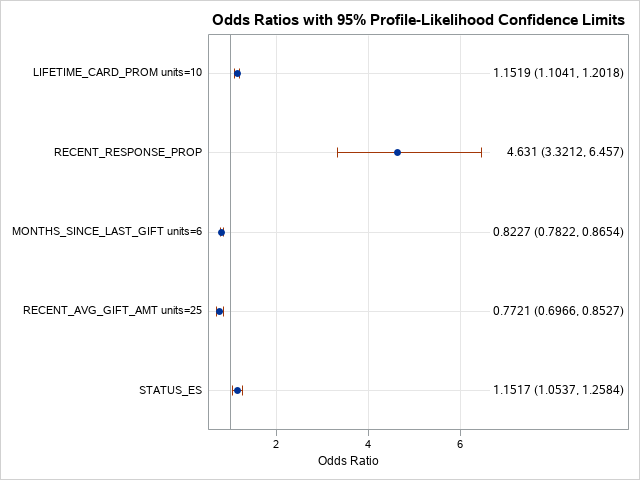
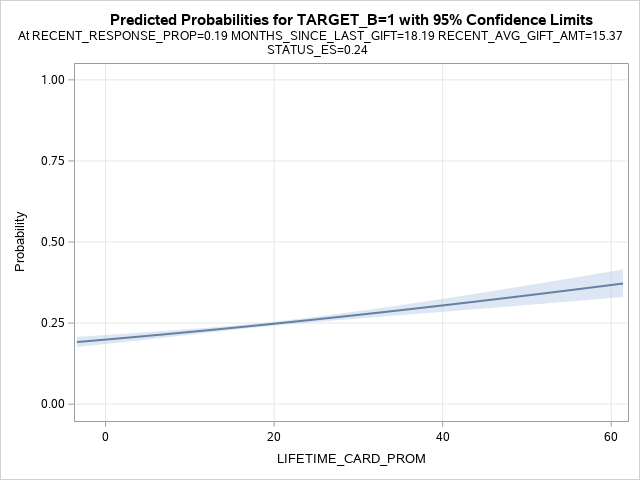
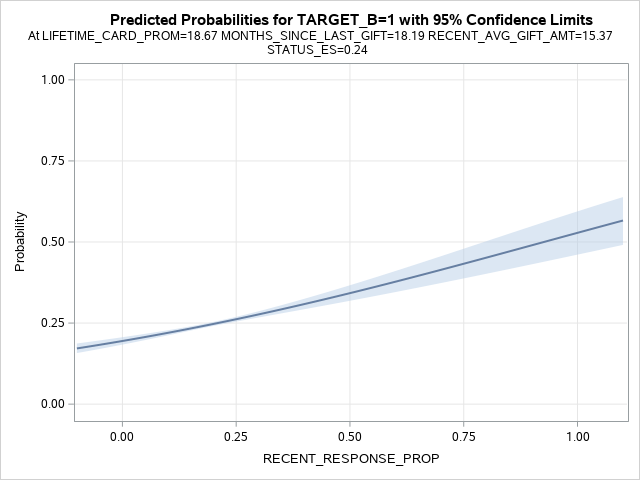
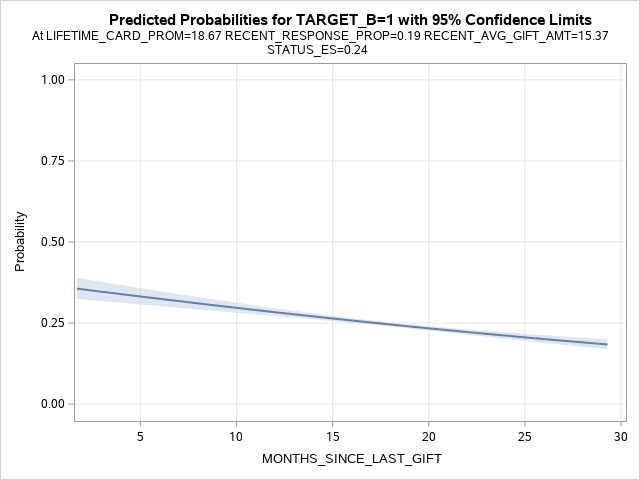
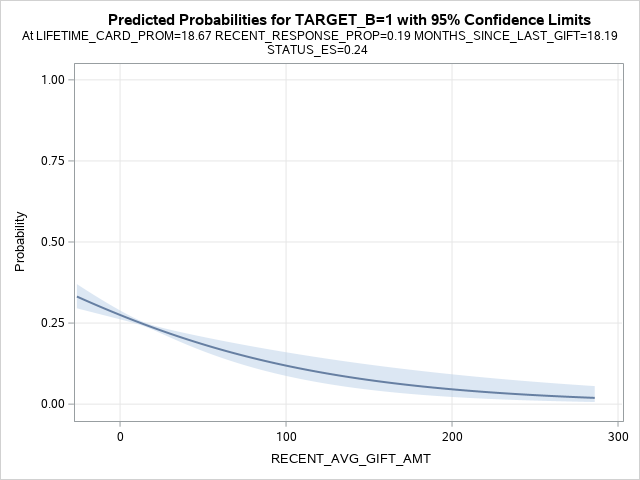
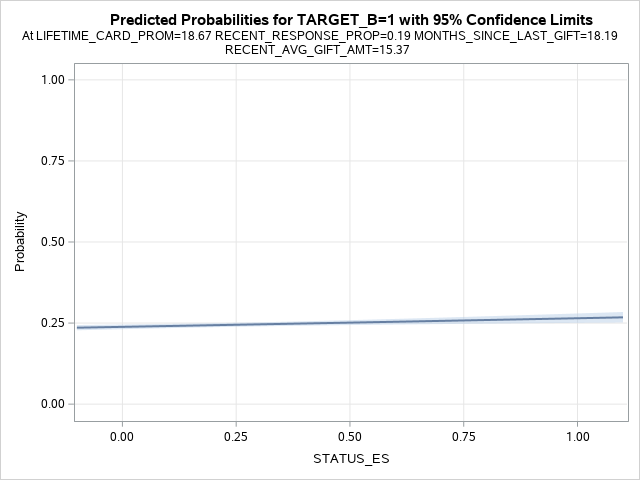

In [9]:

data work.pva(drop=CONTROL_NUMBER MONTHS_SINCE_LAST_PROM_RESP 
              FILE_AVG_GIFT FILE_CARD_GIFT);
   set pmlr.pva_raw_data;
run;

data work.pva;
   set work.pva;
   STATUS_FL=RECENCY_STATUS_96NK in("F","L");
   STATUS_ES=RECENCY_STATUS_96NK in("E","S");
run;

proc logistic data=work.pva plots(only)=(effect(clband
              x=(lifetime_card_prom recent_response_prop
                 months_since_last_gift       
                 recent_avg_gift_amt status_es)) 
                 oddsratio (type=horizontalstat)) 
                 namelen=25;
   model target_b(event='1')= lifetime_card_prom
         recent_response_prop months_since_last_gift
         recent_avg_gift_amt status_es / clodds=pl stb;
   units lifetime_card_prom=10 months_since_last_gift=6
         recent_avg_gift_amt=25 / default=1;
run;